**Names of all group members**: Giulio Vittorio Carassai, Soren Lambrecht, Alihan Kerestecioglu

Follow the template below.

In [2]:
import numpy as np
import pandas as pd
import io


# Fix random generation seed for reproducibility
np.random.seed(0)

# Get the file name
file_name = 'freMTPL2freq.csv'

# Read the CSV file into a DataFrame
data = pd.read_csv(file_name)
print(data.shape)

(678007, 1)


# Exercise 1 (Poisson GLM)

### Question 1.a

In [5]:
# Read the data from the csv file 'freMTPL2freq.csv'
data = pd.read_csv('freMTPL2freq.csv', sep=';', index_col=False)
print('data shape: ',data.shape)
#find nan values in data
print('raw data nan values: ', data.isna().sum())
print('---------------')
print(np.max(data['VehAge']), np.min(data['VehAge']))
print('-----------------')

data.loc[data['VehPower'] >= 9, 'VehPower'] = 9
data['VehPower'] = data['VehPower'].astype('category')
#VehAge: convert to categorical feature with levels [0, 6), [6, 13), [13, ∞) by using pd.cut
# FIX: bins should be 0, 7, 14 to work with 0,6) etc
bins = [0, 7, 14, np.inf]
labels = ['[0, 6)', '[6, 13)', '[13, ∞)']
# Create a new column 'VehAge_binned' with the categorical feature
data['VehAge'] = pd.cut(data['VehAge'], bins=bins, labels=labels, right=False)
##drop drivAge and BonusMalus later
#DrivAge: transform to log(DrivAge).
data['logDrivAge'] = np.log(data['DrivAge'])
#create logBonusMalus feature
data['logBonusMalus'] = data['BonusMalus']
#logBonusMalus: set to 150 for all values greater than 150
data.loc[data['logBonusMalus'] > 150, 'logBonusMalus'] = 150
data['logBonusMalus'] = np.log(data['logBonusMalus'])

data.head()

data shape:  (678007, 11)
raw data nan values:  PolicyID      0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
Exposure      0
ClaimNb       0
dtype: int64
---------------
100 0
-----------------


,PolicyID,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Exposure,ClaimNb,logDrivAge,logBonusMalus
0,1,4,"[6, 13)",23,100,B6,Regular,7887,R31,"0,76",0,3.135494,4.605170
1,2,4,"[0, 6)",26,100,B6,Regular,2308,R31,"0,74",0,3.258097,4.605170
2,3,4,"[0, 6)",26,100,B6,Regular,2308,R31,"0,11",0,3.258097,4.605170
3,4,7,"[0, 6)",44,50,B6,Regular,37,R94,"0,83",0,3.784190,3.912023
4,5,5,"[0, 6)",29,90,B6,Regular,335,R91,"0,69",0,3.367296,4.499810


In [6]:
#convert 'Exposure' to float
data['Exposure'] = data['Exposure'].str.replace(',', '.').astype(float)
print(data.dtypes)

#make sure no nans
print('data nan values: ', data.isna().sum())

PolicyID            int64
VehPower         category
VehAge           category
DrivAge             int64
BonusMalus          int64
VehBrand           object
VehGas             object
Density             int64
Region             object
Exposure          float64
ClaimNb             int64
logDrivAge        float64
logBonusMalus     float64
dtype: object
data nan values:  PolicyID         0
VehPower         0
VehAge           0
DrivAge          0
BonusMalus       0
VehBrand         0
VehGas           0
Density          0
Region           0
Exposure         0
ClaimNb          0
logDrivAge       0
logBonusMalus    0
dtype: int64


In [7]:
#create a X and y dataframes
y = data['ClaimNb']/data['Exposure']
#add exposure
y = pd.concat([y, data['Exposure']], axis=1)
#rename columns to frequency and exposure
y.columns = ['Frequency','Exposure']
#add ClaimNb to y
y = pd.concat([y, data['ClaimNb']], axis=1)
#drop ClaimNb, Exposure, PolicyID, DrivAge, BonusMalus from X
X = data.drop(['ClaimNb', 'Exposure', 'PolicyID', 'DrivAge', 'BonusMalus'], axis=1)

print('data shape: ',X.shape)
y.head()


data shape:  (678007, 8)


,Frequency,Exposure,ClaimNb
0,0.0,0.76,0
1,0.0,0.74,0
2,0.0,0.11,0
3,0.0,0.83,0
4,0.0,0.69,0


In [8]:
from sklearn.preprocessing import StandardScaler

#standardise numerical features
scaler = StandardScaler()
#get all numerical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
print('numerical_features: ',numerical_features)
#standardise numerical features
X[numerical_features] = scaler.fit_transform(X[numerical_features])
X.head()

numerical_features:  Index(['Density', 'logDrivAge', 'logBonusMalus'], dtype='object')


,VehPower,VehAge,VehBrand,VehGas,Density,Region,logDrivAge,logBonusMalus
0,4,"[6, 13)",B6,Regular,1.539553,R31,-1.979858,2.414806
1,4,"[0, 6)",B6,Regular,0.130238,R31,-1.596148,2.414806
2,4,"[0, 6)",B6,Regular,0.130238,R31,-1.596148,2.414806
3,7,"[0, 6)",B6,Regular,-0.443441,R94,0.050374,-0.669202
4,5,"[0, 6)",B6,Regular,-0.368163,R91,-1.254385,1.946027


In [11]:
#transform categorical features to dummy variables
#find categorical features
cat_features = X.select_dtypes(include=['category', 'object']).columns
#Perform one-hot encoding of categorical features
X = pd.get_dummies(X, columns=cat_features, drop_first=True).astype(float)
X.head()

,Density,logDrivAge,logBonusMalus,VehPower_5,VehPower_6,VehPower_7,VehPower_8,VehPower_9,"VehAge_[6, 13)","VehAge_[13, ∞)",...,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
0,1.539553,-1.979858,2.414806,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.130238,-1.596148,2.414806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.130238,-1.596148,2.414806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.443441,0.050374,-0.669202,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.368163,-1.254385,1.946027,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Question 1.b

In [13]:
# my kernel dies when I run this cell !!!
# Perform a 90%-10% train-test split of the data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_poisson_deviance

# Split the data into train and test sets with 90% and 10% of the data respectively - also splitting initial data as it is used later
X_train, X_test, y_train, y_test, data_train, data_test = train_test_split(X, y, data, test_size=0.1, random_state=0)


In [16]:
#fit the model with 'Frequency' as response variable
#set seed to be reproducible
np.random.seed(0)
#fit the model with 'Exposure' as response variable
model = PoissonRegressor(alpha=1e-4, solver="newton-cholesky")
model.fit(X_train, y_train['Frequency'], sample_weight=y_train['Exposure'])

#report the metrics on train set
y_pred_train = model.predict(X_train)
#check that predictions are positive
print('min of predictions: ', np.min(y_pred_train))
print('-------------------')
#MAE
print('MAE on train set: ', mean_absolute_error(y_train['Frequency'], y_pred_train, sample_weight=y_train['Exposure']))
#MSE
print('MSE on train set: ', mean_squared_error(y_train['Frequency'], y_pred_train, sample_weight=y_train['Exposure']))
#weighted Poisson deviance on train and test sets
print('weighted Poisson deviance on train set: ',
      mean_poisson_deviance(y_train['Frequency'], y_pred_train, sample_weight=y_train['Exposure']))

print('-------------------')
#report the metrics on test set
y_pred_test = model.predict(X_test)
print('min of predictions: ', np.min(y_pred_test))
print('-------------------')
#MAE
print('MAE on test set: ', mean_absolute_error(y_test['Frequency'], y_pred_test, sample_weight=y_test['Exposure']))
#MSE
print('MSE on test set: ', mean_squared_error(y_test['Frequency'], y_pred_test, sample_weight=y_test['Exposure']))
#weighted Poisson deviance on train and test sets
print('weighted Poisson deviance on test set: ',
      mean_poisson_deviance(y_test['Frequency'], y_pred_test, sample_weight=y_test['Exposure']))

min of predictions:  0.021512409698136746
-------------------
MAE on train set:  0.1377722149678692
MSE on train set:  0.2369340215866769
weighted Poisson deviance on train set:  0.4574326682196472
-------------------
min of predictions:  0.022436265627125054
-------------------
MAE on test set:  0.1382441125432803
MSE on test set:  0.23986073980822586
weighted Poisson deviance on test set:  0.45995275378505307


### Question 1.c

In [19]:
# Agument the data with the following features
#(DrivAge, DrivAge**2, BonusMalus · DrivAge, BonusMalus · DrivAge2
#train set
data_train['DrivAge2'] = data_train['DrivAge']**2
data_train['BonusMalus*DrivAge']=  data_train['BonusMalus']*data_train['DrivAge']
data_train['BonusMalus*(DrivAge^2'] = data_train['BonusMalus']*(data_train['DrivAge']**2)
#test set
data_test['DrivAge2'] = data_test['DrivAge']**2
data_test['BonusMalus*DrivAge']= data_test['BonusMalus']*data_test['DrivAge']
data_test['BonusMalus*(DrivAge^2'] = data_test['BonusMalus']*(data_test['DrivAge']**2)

#create variable with new features
new_features = ['DrivAge', 'DrivAge2','BonusMalus*DrivAge','BonusMalus*(DrivAge^2']
#add these new features to X_train and X_test
X_train_enhanced = X_train
X_train_enhanced = pd.concat([X_train, data_train[new_features]], axis=1)
X_test_enhanced = X_test
X_test_enhanced = pd.concat([X_test, data_test[new_features]], axis=1)

#scale the new features
X_train_enhanced[new_features] = scaler.fit_transform(X_train_enhanced[new_features])
X_test_enhanced[new_features] = scaler.transform(X_test_enhanced[new_features])

print(X_train_enhanced.shape)
print(X_test_enhanced.shape)

X_train_enhanced.head()

(610206, 46)
(67801, 46)


,Density,logDrivAge,logBonusMalus,VehPower_5,VehPower_6,VehPower_7,VehPower_8,VehPower_9,"VehAge_[6, 13)","VehAge_[13, ∞)",...,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94,DrivAge,DrivAge2,BonusMalus*DrivAge,BonusMalus*(DrivAge^2
395062,-0.424242,1.547913,-0.669202,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.804860,1.988069,1.222051,1.703555
139284,-0.412622,-1.718897,1.014569,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.449513,-1.179080,-1.027462,-1.099579
366822,-0.391403,0.256804,-0.669202,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.106926,-0.043037,-0.342827,-0.219292
309193,-0.380541,1.173770,3.151226,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.238882,1.219232,6.287043,4.640678
297918,-0.343912,0.691323,-0.669202,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.602157,0.464022,0.113596,0.260741


In [20]:
#Train the Poisson GLM with same y and new X
np.random.seed(0)
model = PoissonRegressor(alpha=1e-4, solver="newton-cholesky")
model.fit(X_train_enhanced, y_train['Frequency'], sample_weight=y_train['Exposure'])

#report the metrics on train set
y_pred_train = model.predict(X_train_enhanced)
print('min of predictions: ', np.min(y_pred_train))
print('-------------------')
#MAE
print('MAE on train set: ', mean_absolute_error(y_train['Frequency'], y_pred_train, sample_weight=y_train['Exposure']))
#MSE
print('MSE on train set: ', mean_squared_error(y_train['Frequency'], y_pred_train, sample_weight=y_train['Exposure']))
#weighted Poisson deviance on train and test sets
print('weighted Poisson deviance on train set: ',
      mean_poisson_deviance(y_train['Frequency'], y_pred_train, sample_weight=y_train['Exposure']))

print('-------------------')
#report the metrics on test set
y_pred_test = model.predict(X_test_enhanced)
print('min of predictions: ', np.min(y_pred_test))
print('-------------------')
#MAE
print('MAE on test set: ', mean_absolute_error(y_test['Frequency'], y_pred_test, sample_weight=y_test['Exposure']))
#MSE
print('MSE on test set: ', mean_squared_error(y_test['Frequency'], y_pred_test, sample_weight=y_test['Exposure']))
#weighted Poisson deviance on train and test sets
print('weighted Poisson deviance on test set: ',
      mean_poisson_deviance(y_test['Frequency'], y_pred_test, sample_weight=y_test['Exposure']))

min of predictions:  0.01738145443209856
-------------------
MAE on train set:  0.1377881978150361
MSE on train set:  0.23691503159475838
weighted Poisson deviance on train set:  0.4569589827562568
-------------------
min of predictions:  0.017377659842725546
-------------------
MAE on test set:  0.13823369562295265
MSE on test set:  0.23983130764917587
weighted Poisson deviance on test set:  0.4594603724313381


### Q: Why is the model performance better?

The model is performing slightly better as there are additional non-linear dependencies between features and frequencies.

As hinted, a clear justification for these non-linearities can be seen in the relationship between DrivAge and BonusMalus. Indeed, since all new drivers are assigned a score of 100, this feature won't be very informative for young drivers. The score increases if accidents occur, otherwise it decreases (it therefore becomes a very informative features as age increases). This is why considering features like BounsMalus*DrivAge and BonusMalus*DrivAge^2, "contestualizes" the BonusMalus score for the model in terms of age and therefore leads to better predictions.

<ipython-input-70-a0be1682e0c6>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp_d = temp.groupby('DrivAge').sum()


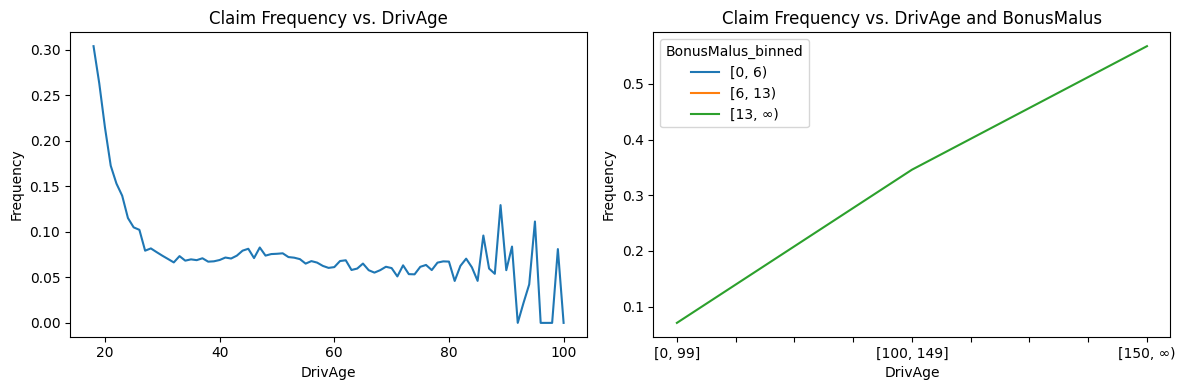

In [70]:
import matplotlib.pyplot as plt

# Create a temporary DataFrame with DrivAge, ClaimNb, Exposure, and BonusMalus
temp = pd.concat([data['DrivAge'], data['ClaimNb'], data['Exposure'], data['BonusMalus']], axis=1)

# Create binned columns for DrivAge and BonusMalus
temp['DrivAge_binned'] = pd.cut(temp['DrivAge'], bins=[0, 7, 14, np.inf], labels=['[0, 6)', '[6, 13)', '[13, ∞)'])
temp['BonusMalus_binned'] = pd.cut(temp['BonusMalus'], bins=[0, 100, 150, np.inf], labels=['[0, 99]', '[100, 149]', '[150, ∞)'])

# Group temp by DrivAge and sum ClaimNb, Exposure
temp_d = temp.groupby('DrivAge').sum()

# Compute claim frequency
temp_d['Frequency'] = temp_d['ClaimNb'] / temp_d['Exposure']

# Group temp by binned DrivAge and BonusMalus
#impossible to see trends in the plot if not binned
temp_db_binned = temp.groupby(['DrivAge_binned', 'BonusMalus_binned']).sum()

# Compute claim frequency
temp_db_binned['Frequency'] = temp_db_binned['ClaimNb'] / temp_db_binned['Exposure']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot claim frequency as a function of DrivAge
temp_d['Frequency'].plot(ax=ax1)
ax1.set_title('Claim Frequency vs. DrivAge')
ax1.set_xlabel('DrivAge')
ax1.set_ylabel('Frequency')

# Plot claim frequency as a function of binned DrivAge and BonusMalus
temp_db_binned['Frequency'].unstack().T.plot(ax=ax2)
ax2.set_title('Claim Frequency vs. DrivAge and BonusMalus')
ax2.set_xlabel('DrivAge')
ax2.set_ylabel('Frequency')
ax2.legend(title='BonusMalus_binned', loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Hint: remember that BonusMalus starts at 100 for new drivers
# and it either reduces (if no accidents happen) or it increases (if accidents happen).
# Therefore if an old driver has a high BonusMalus score, we can deduce that...

# Exercise 2 (Neural network)

### Question 2.a

In [22]:
# Implement the neural network.
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the neural network
class Net(nn.Module):
    def __init__(self, input_size ,hidden_size1, hidden_size2, hidden_size3 ,output_size=1, dropout=0.1):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3
        self.output_size = output_size
        self.dropout = dropout

        self.fc1 = nn.Linear(self.input_size, self.hidden_size1)
        self.fc2 = nn.Linear(self.hidden_size1, self.hidden_size2)
        self.fc3 = nn.Linear(self.hidden_size2, self.hidden_size3)
        self.fc4 = nn.Linear(self.hidden_size3, self.output_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.exponential = nn.ELU() # can try this later on might improve the results
        self.dropout = nn.Dropout(self.dropout)

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        #x = self.dropout(x) # might remove this later on
        x = self.tanh(self.fc2(x))
        #x = self.dropout(x) # might remove this later on
        x = self.tanh(self.fc3(x))
        x = torch.exp(self.fc4(x))
        return x


In [23]:
#prepare data for pytorch
X_train_tensor = torch.tensor(X_train.values).float()
X_test_tensor = torch.tensor(X_test.values).float()

# Transform exposure to a tensor
exposure_train_tensor = torch.tensor(y_train['Exposure'].values).float()
exposure_test_tensor = torch.tensor(y_test['Exposure'].values).float()

y_train_tensor = torch.tensor(y_train['ClaimNb'].values).float()
y_test_tensor = torch.tensor(y_test['ClaimNb'].values).float()

print('shape of X_train: ', X_train_tensor.shape)
print('shape of y_train: ', y_train_tensor.shape)
print('shape of exposure_train: ', exposure_train_tensor.shape)

shape of X_train:  torch.Size([610206, 42])
shape of y_train:  torch.Size([610206])
shape of exposure_train:  torch.Size([610206])


### Question 2.b

In [30]:
# ATTENTION! Make sure your network is trained by minimizing the weighted Poisson deviance in (2).
# You must write a custom loss function.
class PoissonDevianceLoss(torch.nn.Module):
    def forward(self, outputs, targets, exposures):
        #handle the case where outputs is 0
        #version 1
        #epsilon = 1e-6
        #from moodle
        log_targets = torch.where(targets == 0, torch.zeros_like(targets), torch.log(targets))
        log_outputs = torch.where(outputs == 0, torch.zeros_like(outputs), torch.log(outputs))

        loss = 2 * (outputs - targets - targets * log_outputs + targets * log_targets)
        weighted_loss = torch.sum(exposures * loss) / torch.sum(exposures)
        return weighted_loss
    

# Create an instance of the loss function
criterion = PoissonDevianceLoss()


# Create the network and define optimizer
model = Net(input_size=X_train_tensor.shape[1], hidden_size1=128, hidden_size2=64, hidden_size3=64) #change hyperparams

optimizer = optim.Adam(model.parameters(), lr=0.001) #hyperparameter

# Train the network
num_epochs = 100 #hyperparameter
batch_size = 10_000 #hyperparameter

#training mode
model.train()

for epoch in range(num_epochs):
    #shuffle the data
    indices = torch.randperm(X_train_tensor.shape[0]) #cant learn the data, might take this out later
    for i in range(0, X_train_tensor.shape[0], batch_size):
        # Get mini-batch inputs and outputs
        #inputs = X_train[i:i + batch_size]
        inputs = X_train_tensor[indices[i:i + batch_size]]
        #targets = y_train[i:i + batch_size].unsqueeze(-1)
        targets = y_train_tensor[indices[i:i + batch_size]].unsqueeze(-1) #check dims
        #exposures = exposure_train[i:i + batch_size].unsqueeze(-1)
        exposures = exposure_train_tensor[indices[i:i + batch_size]].unsqueeze(-1) #check dims
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass, backward pass, and optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets, exposures)
        loss.backward()
        optimizer.step()

    #print the loss of every epoch
    print('Epoch %d/%d, Trained loss: %.4f' % (epoch + 1, num_epochs, loss.item()))



Epoch 1/100, Trained loss: 0.3187
Epoch 2/100, Trained loss: 0.2592
Epoch 3/100, Trained loss: 0.1928
Epoch 4/100, Trained loss: 0.2244
Epoch 5/100, Trained loss: 0.2275
Epoch 6/100, Trained loss: 0.3259
Epoch 7/100, Trained loss: 0.3109
Epoch 8/100, Trained loss: 0.1900
Epoch 9/100, Trained loss: 0.3853
Epoch 10/100, Trained loss: 0.2837
Epoch 11/100, Trained loss: 0.2344
Epoch 12/100, Trained loss: 0.3349
Epoch 13/100, Trained loss: 0.3218
Epoch 14/100, Trained loss: 0.2152
Epoch 15/100, Trained loss: 0.2635
Epoch 16/100, Trained loss: 0.1474
Epoch 17/100, Trained loss: 0.3759
Epoch 18/100, Trained loss: 0.3121
Epoch 19/100, Trained loss: 0.1499
Epoch 20/100, Trained loss: 0.2330
Epoch 21/100, Trained loss: 0.2688
Epoch 22/100, Trained loss: 0.2542
Epoch 23/100, Trained loss: 0.2488
Epoch 24/100, Trained loss: 0.3210
Epoch 25/100, Trained loss: 0.2958
Epoch 26/100, Trained loss: 0.2152
Epoch 27/100, Trained loss: 0.3473
Epoch 28/100, Trained loss: 0.2341
Epoch 29/100, Trained loss: 0

In [32]:
# Set model to evaluation mode
model.eval()

# Evaluate the model on the training set
with torch.no_grad():
    # Forward pass for training set
    train_outputs = model(X_train_tensor)
    train_loss = criterion(train_outputs, y_train_tensor.unsqueeze(-1), exposure_train_tensor.unsqueeze(-1))

    # Print training set metrics
    print('Weighted Poisson deviance on training: %.4f' % (train_loss.item()))
    print('MSE on training set: ', mean_squared_error(y_train_tensor, train_outputs, sample_weight=exposure_train_tensor))
    print('MAE on training set: ', mean_absolute_error(y_train_tensor, train_outputs, sample_weight=exposure_train_tensor))

print('------------')
# Evaluate the model on the test set
with torch.no_grad():
    # Forward pass for test set
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor.unsqueeze(-1), exposure_test_tensor.unsqueeze(-1))

    # Print test set metrics
    print('Weighted Poisson deviance on test: %.4f' % (test_loss.item()))
    print('MSE on test set: ', mean_squared_error(y_test_tensor, test_outputs, sample_weight=exposure_test_tensor))
    print('MAE on test set: ', mean_absolute_error(y_test_tensor, test_outputs, sample_weight=exposure_test_tensor))

# If your network does not outperform the Poisson GLM, improve its performance
# by adding more neurons, changing the learning rate, performing regularization, adding hidden layers, ...


Weighted Poisson deviance on training: 0.2914
MSE on training set:  0.052852497
MAE on training set:  0.09464307
------------
Weighted Poisson deviance on test: 0.2961
MSE on test set:  0.052700758
MAE on test set:  0.09516693


# Exercise 3 (Tree-based methods)

### Question 3.a

In [42]:
from sklearn.preprocessing import LabelEncoder
# recreating original X and y dataframes from 1a) without one hot encoder to increase speed
y = data['ClaimNb']/data['Exposure']
# add exposure
y = pd.concat([y, data['Exposure']], axis=1)
# rename columns to frequency and exposure
y.columns = ['Frequency','Exposure']
y = pd.concat([y, data['ClaimNb']], axis=1)

# drop ClaimNb, Exposure, PolicyID, DrivAge, BonusMalus from X
X = data.drop(['ClaimNb', 'Exposure', 'PolicyID', 'DrivAge', 'BonusMalus'], axis=1)

# change categorical fatures with label encoder - more efficicent in trees
le = LabelEncoder()
# find categorical features
cat_features = X.select_dtypes(include=['category', 'object']).columns
print('categorical features: ',cat_features)
# encode categorical features

for col in cat_features:
    X[col] = le.fit_transform(X[col])

print('data shapes: ', 'X: ',X.shape,'y: ', y.shape)


categorical features:  Index(['VehPower', 'VehAge', 'VehBrand', 'VehGas', 'Region'], dtype='object')
data shapes:  X:  (678007, 8) y:  (678007, 3)


In [43]:
#scale X non categorical features
#import scaler
from sklearn.preprocessing import StandardScaler
#import train_test_split
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
#get the features that are no cat_features
non_cat_features = X.columns.difference(cat_features)
print('non_cat_features: ', non_cat_features)
#standardise numerical features
X[non_cat_features] = scaler.fit_transform(X[non_cat_features])
#and split the data into train and test sets with 90% and 10% of the data respectively
X_train, X_test, y_train, y_test, data_train, data_test = train_test_split(X, y, data, test_size=0.1, random_state=0)
#print shapes
print('data shapes: ', 'X_train: ',X_train.shape,'y_train: ', y_train.shape, 'X_test: ',X_test.shape,'y_test: ', y_test.shape)

non_cat_features:  Index(['Density', 'logBonusMalus', 'logDrivAge'], dtype='object')
data shapes:  X_train:  (610206, 8) y_train:  (610206, 3) X_test:  (67801, 8) y_test:  (67801, 3)


In [35]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_poisson_deviance


# Define the regression tree model with poission scorer built in
regression_tree = DecisionTreeRegressor(criterion='poisson', random_state=0)

# Define the parameter grid for GridSearchCV
param_grid = {
    'min_impurity_decrease': [0, 0.0001, 0.001, 0.01, 0.1, 1]
    }

poisson_scorer = make_scorer(mean_poisson_deviance, greater_is_better=False)

# Create the GridSearchCV object with custom scoring using the MAE loss function
grid_search = GridSearchCV(regression_tree, param_grid, scoring=poisson_scorer, cv=5)

# Fit the model to the data and set weights to Exposure
grid_search.fit(X_train, y_train['Frequency'], sample_weight=y_train['Exposure'])

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'min_impurity_decrease': 0.0001}


In [36]:
#report the MAE, MSE and weighted Poisson deviance on train and test set
#train set
y_pred_train = grid_search.predict(X_train)
print('MAE on train set: ', mean_absolute_error(y_train['Frequency'], y_pred_train, sample_weight=y_train['Exposure']))
#MSE
print('MSE on train set: ', mean_squared_error(y_train['Frequency'], y_pred_train, sample_weight=y_train['Exposure']))
#weighted Poisson deviance on train and test sets
print('weighted Poisson deviance on train set: ',
      mean_poisson_deviance(y_train['Frequency'], y_pred_train, sample_weight=y_train['Exposure']))

#report the metrics on test set
y_pred_test = grid_search.predict(X_test)
#MAE
print('MAE on test set: ', mean_absolute_error(y_test['Frequency'], y_pred_test, sample_weight=y_test['Exposure']))
#MSE
print('MSE on test set: ', mean_squared_error(y_test['Frequency'], y_pred_test, sample_weight=y_test['Exposure']))
#weighted Poisson deviance on train and test sets
print('weighted Poisson deviance on test set: ',
      mean_poisson_deviance(y_test['Frequency'], y_pred_test, sample_weight=y_test['Exposure']))

MAE on train set:  0.13708562742590036
MSE on train set:  0.2364265867521381
weighted Poisson deviance on train set:  0.45407709345735314
MAE on test set:  0.1376553906675684
MSE on test set:  0.23931919401531837
weighted Poisson deviance on test set:  0.45646883917179


### Question 3.b

In [45]:
#implement a random forest
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, criterion='poisson', random_state=0)

# ATTENTION! Make sure your model is trained by minimizing the weighted Poisson deviance in (2).
poisson_scorer = make_scorer(mean_poisson_deviance, greater_is_better=False)

# Define the parameter grid for GridSearchCV - start by cross-validating on the number of features to consider when looking for the best split.
#'min_impurity_decrease': [0, 0.0001, 0.001], 'max_features': [3, 5, 7, 9] or 'max_features': ['auto', 'sqrt', 'log2']
param_grid = {
    'min_impurity_decrease': [0, 0.0001, 0.001],
    'max_features': ['auto', 'sqrt', 'log2'] # None instead of 'auto' to avoid deprecated error !!!
    }

# Cross-validation
grid_search = GridSearchCV(model, param_grid, scoring=poisson_scorer, cv=5) #can change cv to 10
grid_search.fit(X_train, y_train['Frequency'], sample_weight=y_train['Exposure'])

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'max_features': 'log2', 'min_impurity_decrease': 0.0001}


In [38]:
#report the MAE, MSE and weighted Poisson deviance on train and test set
#train set
y_pred_train = grid_search.predict(X_train)
print('MAE on train set: ', mean_absolute_error(y_train['Frequency'], y_pred_train, sample_weight=y_train['Exposure']))
#MSE
print('MSE on train set: ', mean_squared_error(y_train['Frequency'], y_pred_train, sample_weight=y_train['Exposure']))
#weighted Poisson deviance on train and test sets
print('weighted Poisson deviance on train set: ',
      mean_poisson_deviance(y_train['Frequency'], y_pred_train, sample_weight=y_train['Exposure']))

#report the metrics on test set
y_pred_test = grid_search.predict(X_test)
#MAE
print('MAE on test set: ', mean_absolute_error(y_test['Frequency'], y_pred_test, sample_weight=y_test['Exposure']))
#MSE
print('MSE on test set: ', mean_squared_error(y_test['Frequency'], y_pred_test, sample_weight=y_test['Exposure']))
#weighted Poisson deviance on train and test sets
print('weighted Poisson deviance on test set: ',
      mean_poisson_deviance(y_test['Frequency'], y_pred_test, sample_weight=y_test['Exposure']))

MAE on train set:  0.1383301311134012
MSE on train set:  0.2368370744159298
weighted Poisson deviance on train set:  0.45596511496889747
MAE on test set:  0.13896798440854216
MSE on test set:  0.23973938724024443
weighted Poisson deviance on test set:  0.45817825617626806


### Question 3.c

In [39]:
# Implement gradient boosted trees using hist gradient boosting
from sklearn.ensemble import HistGradientBoostingRegressor

#set eraly stopping to false
model = HistGradientBoostingRegressor(loss='poisson', random_state=0, early_stopping=False)

#shrinkage parameter and the number of boosting steps - 'max_iter': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_iter': [50, 100, 200]
    }

# ATTENTION! Make sure your model is trained by minimizing the weighted Poisson deviance in (2).
poisson_scorer = make_scorer(mean_poisson_deviance, greater_is_better=False)

grid_search = GridSearchCV(model, param_grid, scoring=poisson_scorer, cv=5) #set to 5 or 10
grid_search.fit(X_train, y_train['Frequency'], sample_weight=y_train['Exposure'])

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# As seen in class, there's a trade-off between shrinkage and number of boosting steps.
# When cross-validating over the number of boosting steps, make sure that your model is
# not early-stopped (switch off early stopping is implemented by default!)

Best Parameters: {'learning_rate': 0.1, 'max_iter': 50}


In [40]:
#report the MAE, MSE and weighted Poisson deviance on train and test set
#train set
y_pred_train = grid_search.predict(X_train)
print('MAE on train set: ', mean_absolute_error(y_train['Frequency'], y_pred_train, sample_weight=y_train['Exposure']))
#MSE
print('MSE on train set: ', mean_squared_error(y_train['Frequency'], y_pred_train, sample_weight=y_train['Exposure']))
#weighted Poisson deviance on train and test sets
print('weighted Poisson deviance on train set: ',
      mean_poisson_deviance(y_train['Frequency'], y_pred_train, sample_weight=y_train['Exposure']))

#report the metrics on test set
y_pred_test = grid_search.predict(X_test)
#MAE
print('MAE on test set: ', mean_absolute_error(y_test['Frequency'], y_pred_test, sample_weight=y_test['Exposure']))
#MSE
print('MSE on test set: ', mean_squared_error(y_test['Frequency'], y_pred_test, sample_weight=y_test['Exposure']))
#weighted Poisson deviance on train and test sets
print('weighted Poisson deviance on test set: ',
      mean_poisson_deviance(y_test['Frequency'], y_pred_test, sample_weight=y_test['Exposure']))


MAE on train set:  0.1356745700760125
MSE on train set:  0.23461915391809668
weighted Poisson deviance on train set:  0.44084389666175927
MAE on test set:  0.13677111059687472
MSE on test set:  0.2385304274373874
weighted Poisson deviance on test set:  0.4496172135276723
